In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pyrepseq as prs
from pyrepseq.metric.tcr_metric import TcrMetric
import pandas as pd
from sceptr import variant
from sklearn import metrics
from typing import List

In [2]:
test_data = pd.read_csv("../tcr_data/preprocessed/benchmarking/vdjdb_cleaned.csv")
background_data = pd.read_csv("../tcr_data/preprocessed/tanno/test.csv")
background_subsample = background_data.sample(n=1000, random_state=420)

models = (
    prs.metric.tcr_metric.Tcrdist(),
    variant.ab_sceptr()
)

In [3]:
background_subsample

,TRAV,CDR3A,TRAJ,TRBV,CDR3B,TRBJ,Epitope,MHCA,MHCB,clone_count,alpha_pgen,beta_pgen
23708,TRAV8-2,CVVSANSGNTPLVF,TRAJ29,TRBV5-1,CASSFTEPYEQYF,TRBJ2-7,NaN,NaN,NaN,1,0.000000e+00,2.161143e-09
53404,TRAV38-2/DV8,CAYRFLNRDDKIIF,TRAJ30,TRBV20-1,CSALLAGGPLDEQFF,TRBJ2-1,NaN,NaN,NaN,1,7.038606e-09,5.201969e-11
37486,TRAV35,CAGLNAGGTSYGKLTF,TRAJ52,TRBV6-5,CASARRPYEQYF,TRBJ2-7,NaN,NaN,NaN,1,1.375298e-06,6.639843e-10
67264,TRAV10,CVVSGPTAGYALNF,TRAJ41,TRBV12-3,CASSFRGLAGPHTSSYNEQFF,TRBJ2-1,NaN,NaN,NaN,1,6.214538e-11,1.137961e-14
45686,TRAV14/DV4,CAMREGSFNKFYF,TRAJ21,TRBV7-9,CASSLEGGEAFF,TRBJ1-1,NaN,NaN,NaN,1,8.696235e-08,1.473519e-08
...,...,...,...,...,...,...,...,...,...,...,...,...
40670,TRAV26-2,CIPKIQGAQKLVF,TRAJ54,TRBV6-5,CASTEVGLGLEFFSGNEQFF,TRBJ2-1,NaN,NaN,NaN,1,9.392406e-09,8.957474e-21
39617,TRAV26-1,CIVNNNARLMF,TRAJ31,TRBV14,CASKGSGPGNEQFF,TRBJ2-1,NaN,NaN,NaN,1,4.053057e-07,3.615262e-12
17688,TRAV2,CASSPGSNYQLIW,TRAJ33,TRBV30,CAWMVPNTGELFF,TRBJ2-2,NaN,NaN,NaN,1,4.575514e-12,7.711235e-11
28290,TRAV26-2,CILRDQRDYKLSF,TRAJ20,TRBV7-2,CASSLGETNYGYTF,TRBJ1-2,NaN,NaN,NaN,1,1.490747e-10,2.536088e-09


In [4]:
epitopes = test_data.Epitope.unique()

def get_benchmark_results(model: TcrMetric) -> dict:
    aucs_per_epitope = dict()

    for epitope in epitopes:
        print(f"Benchmarking for {epitope}...")
        one_shot_aucs = get_one_shot_aucs(model, epitope)
        aucs_per_epitope[epitope] = one_shot_aucs
    
    return aucs_per_epitope

def get_one_shot_aucs(model: TcrMetric, epitope: str) -> List[float]:
    epitope_references = test_data[test_data.Epitope == epitope]
    test_data_for_epitope = pd.concat([epitope_references, background_subsample])
    test_data_epitope_mask = [True] * len(epitope_references) + [False] * len(background_subsample)

    cdist_matrix = model.calc_cdist_matrix(epitope_references, test_data_for_epitope)
    similarity_matrix = np.exp(-cdist_matrix/20)

    aucs = []
    for idx, similarities in enumerate(similarity_matrix):
        similarities = np.delete(similarities, idx)
        ground_truth = np.delete(test_data_epitope_mask, idx)

        aucs.append(metrics.roc_auc_score(ground_truth, similarities))

    return aucs

In [5]:
benchmarks_per_metric = {
    model.name: get_benchmark_results(model) for model in models
}

Benchmarking for GILGFVFTL...
Benchmarking for NLVPMVATV...
Benchmarking for GLCTLVAML...
Benchmarking for YLQPRTFLL...
Benchmarking for LLWNGPMAV...
Benchmarking for CINGVCWTV...
Benchmarking for QYIKWPWYI...
Benchmarking for TFEYVSQPFLMDLE...
Benchmarking for LTDEMIAQY...
Benchmarking for TTDPSFLGRY...
Benchmarking for SPRWYFYYL...
Benchmarking for KTFPPTEPK...
Benchmarking for GILGFVFTL...


/home/yutanagano/miniconda3/envs/sceptr_publication_analyses/lib/python3.11/site-packages/torch/nn/modules/transformer.py:384: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:177.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)


Benchmarking for NLVPMVATV...
Benchmarking for GLCTLVAML...
Benchmarking for YLQPRTFLL...
Benchmarking for LLWNGPMAV...
Benchmarking for CINGVCWTV...
Benchmarking for QYIKWPWYI...
Benchmarking for TFEYVSQPFLMDLE...
Benchmarking for LTDEMIAQY...
Benchmarking for TTDPSFLGRY...
Benchmarking for SPRWYFYYL...
Benchmarking for KTFPPTEPK...


In [6]:
def get_average_aucs(benchmark_dict: dict) -> dict:
    return {
        epitope: np.mean(aucs) for epitope, aucs in benchmark_dict.items()
    }

averages_per_model = {
    model: get_average_aucs(benchmark_dict) for model, benchmark_dict in benchmarks_per_metric.items()
}

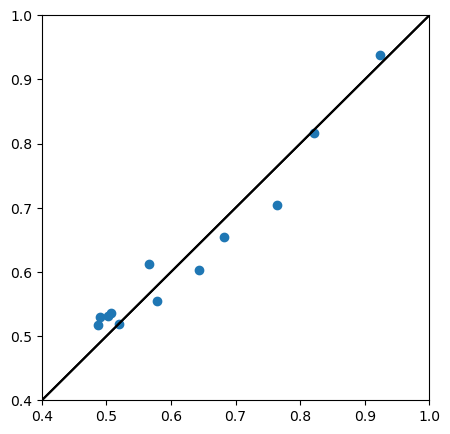

In [7]:
plt.figure(figsize=(5,5))
plt.scatter(averages_per_model["tcrdist"].values(), averages_per_model["AB SCEPTR"].values())
plt.plot(((0,0),(1,1)), c="k")
plt.xlim(0.4,1)
plt.ylim(0.4,1)
plt.show()